# Iterative Prisoner's Dilemma


### Description

The Prisoner’s Dilemma (PD) is a very well known Game Theory case of study, which is widely used to (attempt to) model social/economical interaction. It's a "dilemma" as, if exploited to explain the emergence of altruism in human or in general animal society, it fails badly at a first glance.

In the literature it can be found exposed in different interpretations, and we are going to follow the following one:

*Two people meet and exchange closed bags, with the understanding that one of them contains money, and the other contains a purchase. Either player can choose to honor the deal by putting into his or her bag what he or she agreed, or he or she can defect by handing over an empty bag.*

<img src="bags.png">

In this project we will use the following basic linear algebra framework in order to obtain the players' rewards. Given the payoff matrix $M$, that quantifies the revenue that each player gets depending on whether he cooperates or not, the $i$ player reward can be computed as:

$$
r_i = u_i^T M u_{-i}
$$

where:
\begin{gather*}
    M = 
        \begin{pmatrix}
            2 & 0\\
            3 & 1
        \end{pmatrix}\\\\
    u_{i} =  \text{i-th player move} \\
    u_{-i} =  \text{adversary's move} \\\\
    u_x = 
        \begin{cases}
            \begin{pmatrix}
                1 & 0
            \end{pmatrix}^\intercal \quad \text{when player $x$ collaborates}
        \\\\
            \begin{pmatrix}
                0 & 1
            \end{pmatrix}^\intercal \quad \text{when player $x$ defects}
        \end{cases}
\end{gather*}

<br>


It is obvious that for both players the winning strategy is to not cooperate. In fact defecting is the strincly dominant strategy and this leads to the result that the expected game outcome will be that both players decide to defect, and this outcome will be a Nash Equilibrium.

But we can notice that the reward obtained by each player when they both decide to collaborate would be higher, in fact this outcome would be Pareto Efficient, namely there would be no way in the whole game that a player can improve his reward without the other player reward get worse.

Things changes when the interaction between the two individuals is iterated, in that case a more altruist attitude (strategy) is expected to emerge. The goal of this project is to test this hypothesis.

In an Iterative Prisoner's Dilemma (IPD), two players play prisoner's dilemma more than once in succession and they remember previous actions of their opponent and change their strategy accordingly. The winning strategy is the one which yields to a larger reward at the end of the IPD.

### Assignments

* Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations. 
* Implement a multiple players IPD (MPIPD) where several strategies play against each other in a roud-robin scheme
* Iterate what done in the previous task (repeated MPIPD, rMPIPD)  by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration
* (*difficult*) Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natura selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined.  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from itertools import compress
import copy
import time
from IPython import display

## Abstract class Player

In [2]:
from abc import ABC, abstractmethod

class Player(ABC):

    def __init__(self, r_history=[], move_history=[]):
        self.r_history = copy.deepcopy(r_history)
        self.move_history = copy.deepcopy(move_history)
    
    def append_reward(self, reward):
        self.r_history.append(reward)
    
    # default reset, it will be overridden in 2 classes
    def p_reset(self):
        self.r_history = []
        self.move_history = []
        
    @abstractmethod
    def move(self):
        pass
    

## Player class extensions

The player strategy can be represented as a function which outputs either $u_C$ or $u_D$. Such function can depend on the opponent's history of moves, on his history of moves, on the number of moves played till that moment and so on.<br>
The strategies that we implemented are:

* **Nice guy**: always cooperate (the function's output is always $u_D$)
* **Bad guy**: always defect 
* **Mainly nice**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k<50$
* **Mainly bad**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k>50$
* **tit-for-tat**: start by cooperating, then repeat what the opponent has done in the previous move
* **Grim-Trigger**: start by cooperating, than keep cooperating until any player decides to defect; from that moment on, keep defecting
* **LookBackPlayer**: use past rewards in order to decide the next move.

In [3]:
class NiceGuy(Player):
    """
    Player that always outputs the cooperate move
    """
    def __init__(self, r_history=[], move_history=[]):
        Player.__init__(self, r_history, move_history)
        self.label = "NiceGuy"
        
    def move(self):
        uc = [1,0]
        self.move_history.append(uc)
        return uc
    
    
class BadGuy(Player):
    """
    Player that always outputs the defect move
    """
    def __init__(self, r_history=[], move_history=[]):
        Player.__init__(self, r_history, move_history)
        self.label = "BadGuy"
        
    def move(self):
        ud = [0,1]
        self.move_history.append(ud)
        return ud
    

    
class KBadGuy(Player):
    """
    Player that outputs the defect move 
    with probability k/100
    """
    def __init__(self, k, r_history=[], move_history=[]):
        Player.__init__(self, r_history, move_history)
        self.k = k
        self.label = str(k) + "BadGuy"
        
    def move(self):
        uc = [1,0]
        ud = [0,1]
        if np.random.rand() > 1-(self.k/100):
            u = ud
        else:
            u = uc        
        self.move_history.append(u)
        return u
 
    
class Tit4Tat(Player):
    """
    Player, the first move is cooperate, 
    the subsequent moves are the same as the last 
    element in self.input_history
    """
    def __init__(self, r_history=[], move_history=[], input_history=[]):
        Player.__init__(self, r_history, move_history)
        self.input_history = copy.deepcopy(input_history)

    def append_input(self, inp):
        self.input_history.append(inp)

    def move(self):
        if len(self.input_history) == 0:
            u = [1,0]
        else:
            u = self.input_history[-1]
        self.move_history.append(u)
        return u

    
class Tit4TatMP(Player):
    """
    Player that starts with cooperate and then cooperates only if a fraction of players
    above or equal c_treshold has cooperated.
    """
    def __init__(self, c_threshold=0.5, r_history=[], move_history=[], input_history=[]):
        Player.__init__(self, r_history, move_history)
        self.input_history = copy.deepcopy(input_history)
        self.c_threshold = c_threshold
        self.label = str(c_threshold) + "Tit4TatMP"

    def append_input(self, m_inp):
        """
        multiplayer input m_inp should be an array or list with N rows for N players,
        in every row the list [1,0] or [0,1], it also works with [1] or [0].
        The number of input players can change. 
        """
        self.input_history.append(m_inp)
        
    def move(self):
        if len(self.input_history) == 0:
            u = [1,0]
        else:
            last_inp = np.array(self.input_history[-1])[:,0]
            if np.sum(last_inp)/np.shape(last_inp)[0] >= self.c_threshold:
                u = [1,0]
            else:
                u = [0,1]
        self.move_history.append(u)
        return u
    
    # override
    def p_reset(self):
        self.r_history = []
        self.move_history = []
        self.input_history = []
        
        
class GrimTriggerMP(Player):
    """
    Player that cooperates until a numbers of players >= d_threshold defect in a turn,
    from now on he defects in every turn. 
    Setting d_threshold=0 means that it needs only one defecting player
    to start defecting itself.
    """
    def __init__(self, d_threshold=0.5, r_history=[], move_history=[], input_history=[]):
        Player.__init__(self, r_history, move_history) 
        self.input_history = copy.deepcopy(input_history)
        self.d_threshold = d_threshold
        self.defected = False
        self.label = str(d_threshold) + "GrimTriggerMP"
    
    def append_input(self, m_inp):
        """
        multiplayer input m_inp should be an array or list with N rows for N players,
        in every row the list [1,0] or [0,1], it also works with [1] or [0].
        The number of input players can change. 
        """
        self.input_history.append(m_inp)
    
    def move(self):  
        if not self.defected and len(self.input_history) > 0:
            # check if it has been defected in the last turn
            last_inp = last_inp = np.array(self.input_history[-1])[:,0]
            if np.sum(last_inp)/np.shape(last_inp)[0] < 1 - self.d_threshold:
                self.defected = True
                
        if not self.defected:
            u = [1,0]
        else:
            u = [0,1]
        self.move_history.append(u)
        return u
    
    # override
    def p_reset(self):
        self.r_history = []
        self.move_history = []
        self.input_history = []
        self.defected = False

    
class LookBackPlayer(Player):
    """
    Player that use past rewards in order to decide the next move.
    """
    def __init__(self, bias, r_history=[], move_history=[], delta = 1):
        """
        bias is added to the past rewards during the move decision
        if bias is in range [-3,0] it can change the behaviour of the player
        """
        Player.__init__(self, r_history, move_history) 
        self.bias = bias
        self.delta = delta
        self.label = str(delta) + "LookBackPlayer"
    
    def move(self):       
        # random move if its the first move
        if len(self.r_history) == 0:
            if np.random.rand() >= 0.5:
                u = [1,0]
            else:
                u = [0,1]
        else:            
            move_cat_history = np.array(self.move_history)
            deltas = np.array([self.delta**i for i in range(len(move_cat_history))])
            deltas = np.hstack((deltas,deltas))
            r_cat_history = np.concatenate((np.array([self.r_history]).T,np.array([self.r_history]).T), axis=1)
            sum_cat_r = np.sum((r_cat_history + self.bias) * move_cat_history, axis=0)

            if sum_cat_r[0]>sum_cat_r[1]:
                # cooperate 
                u = [1,0]
            elif sum_cat_r[0]<sum_cat_r[1]:
                # defect 
                u = [0,1]
            else:
                # random choice if parity
                if np.random.rand() >= 0.5:
                    u = [1,0]
                else:
                    u = [0,1]
                
        self.move_history.append(u)
        return u

## Examples of players classes
Simple example about player initialization and methods 

In [4]:
nice_guy = NiceGuy()

for i in range(10):
    u = nice_guy.move()
print(u)

print(nice_guy.move_history)
print(nice_guy.r_history)


[1, 0]
[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
[]


In [5]:
pino = KBadGuy(30)
for i in range(10):
    u = pino.move()
print(u)
print(pino.move_history)

[0, 1]
[[0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1]]


In [6]:
t4t_guy = Tit4Tat()
u = t4t_guy.move()
print("first move ",u)

print(t4t_guy.move_history)
t4t_guy.input_history.append([0,1])
u = t4t_guy.move()
print("second move (mirrored) ", u)

first move  [1, 0]
[[1, 0]]
second move (mirrored)  [0, 1]


In [7]:
t4t_m = Tit4TatMP(c_threshold=0.5)

u = t4t_m.move()
print("first move ", u)

m_inp = [[1,0], [0,1], [0,1]]

t4t_m.append_input(m_inp)

u = t4t_m.move()
print("second move ", u)

m_inp = [[1], [0], [0], [1], [1]]
t4t_m.append_input(m_inp)

u = t4t_m.move()
print("third move ", u)

first move  [1, 0]
second move  [0, 1]
third move  [1, 0]


In [8]:
# with d_threshold=0 it needs one defecting player to change
grim_trigger = GrimTriggerMP(d_threshold=0)
u = grim_trigger.move()
print("first move is cooperate ", u)

# one defector over 4 other players
m_inp = [[1,0], [1,0], [1,0], [0,1]]
grim_trigger.append_input(m_inp)

u = grim_trigger.move()
print("second move ", u)

m_inp = [[1], [1], [1], [1]]
grim_trigger.append_input(m_inp)

u = grim_trigger.move()
print("third move ", u)

u = grim_trigger.move()
print("fourth move ", u)

first move is cooperate  [1, 0]
second move  [0, 1]
third move  [0, 1]
fourth move  [0, 1]


# Part 1: 2 players IPD
Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations.

## KBadGuy vs Tit4Tat
As Tit4Tat copies the KBadGuy, they tend to finish with similar rewards.

Tit4Tat final reward 83
KBadGuy final reward 83


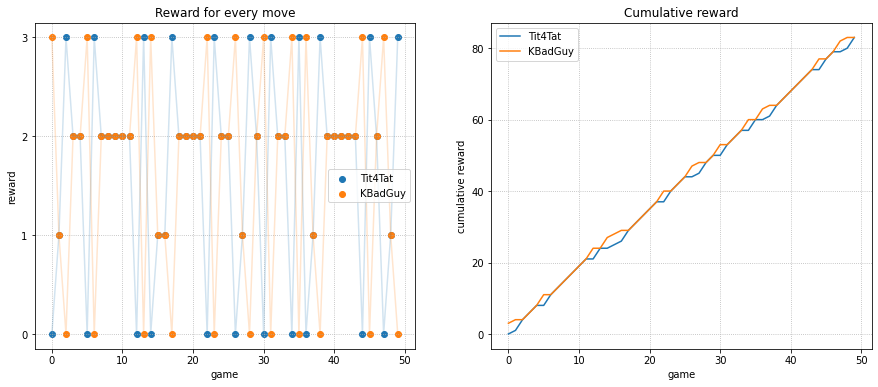

In [9]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

# initialize players instances
p1 = Tit4Tat()
p2 = KBadGuy(40)

# game loop
for i in range(50):
    u1 = p1.move()
    u2 = p2.move()
    #append p2 move, necessary for the tit4tat
    p1.append_input(u2)
    
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)

# visualization
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=(type(p1).__name__),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=(type(p2).__name__),)
ax[0].legend()
ax[0].set_yticks(range(0,4))
ax[0].set_xlabel("game")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every move")

ax[1].plot(np.cumsum(p1.r_history), label=(type(p1).__name__))
ax[1].plot(np.cumsum(p2.r_history), label=(type(p2).__name__))
ax[1].legend()
ax[0].grid(linestyle=":")
ax[1].set_xlabel("game")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")


print(f"{type(p1).__name__} final reward {sum(p1.r_history)}")
print(f"{type(p2).__name__} final reward {sum(p2.r_history)}")

## Tit4Tat vs Tit4Tat
They start by cooperating and continue to cooperate. They finish with the higher overall reward.

Tit4Tat final reward 200
Tit4Tat final reward 200


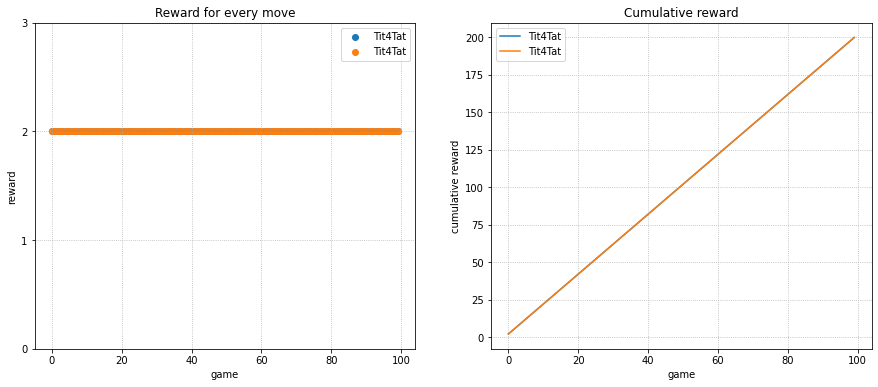

In [10]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

p1 = Tit4Tat()
p2 = Tit4Tat()

# game loop
for i in range(100):
    u1 = p1.move()
    p2.append_input(u1)
    
    u2 = p2.move()
    p1.append_input(u2)
        
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)
    
# visualization    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=(type(p1).__name__),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=(type(p2).__name__),)
ax[0].legend()
ax[0].set_yticks(range(0,4))
ax[0].grid(linestyle=":")
ax[0].set_xlabel("game")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every move")

ax[1].plot(np.cumsum(p1.r_history), label=(type(p1).__name__))
ax[1].plot(np.cumsum(p2.r_history), label=(type(p2).__name__))
ax[1].legend()
ax[1].set_xlabel("game")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")


print(f"{type(p1).__name__} final reward {sum(p1.r_history)}")
print(f"{type(p2).__name__} final reward {sum(p2.r_history)}")

## KBadGuy vs KBadGuy
The KBadGuy with higher k parameter tends to win.

player1 final reward  68
player2 final reward  107


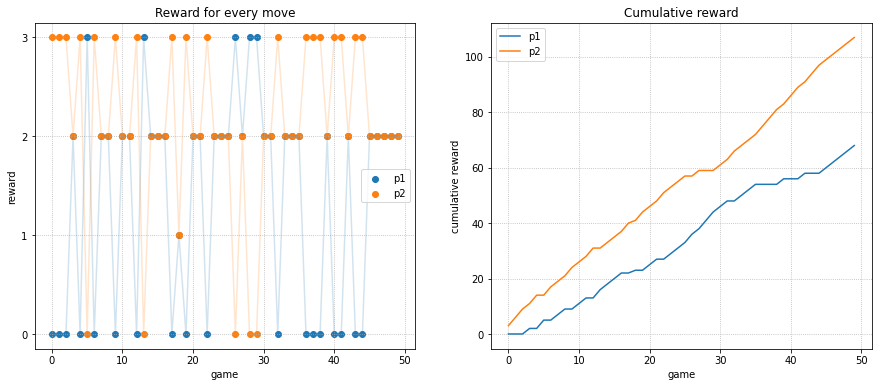

In [11]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

# initialize players instances
p1 = KBadGuy(10)
p2 = KBadGuy(30)

# game loop
for i in range(50):
    u1 = p1.move()    
    u2 = p2.move()
 
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)
    
# visualization
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=("p1"),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=("p2"),)
ax[0].legend()
ax[0].set_yticks(range(0,4))
ax[0].set_xlabel("game")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every move")
ax[0].grid(linestyle=":")

ax[1].plot(np.cumsum(p1.r_history), label=("p1"))
ax[1].plot(np.cumsum(p2.r_history), label=("p2"))
ax[1].legend()
ax[1].set_xlabel("game")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")


print("player1 final reward ", sum(p1.r_history))
print("player2 final reward ", sum(p2.r_history))

## Explore the entire range of KBadGuys

We can generalize the previous cell. The entire range of the KBadGuys comprends the NiceGuy (with *k*=0), the BadGuy (with *k*=100) and every strategy inbetween, so we run every possible game while varying the *k* in the two players. We also want to analize the connection between the two *k* values and the overall reward value.

Since every tournament is defined on the variation on two parameters we need to display the reward in a figure using two axis and color. With this result we can prove that the higher overall reward is obtained when the two players have a low *k* parameter.
So the higher individual reward is obtained with a defective strategy, but the higher group reward, intended as the summation of the individual rewards, is obtained with a cooperative behaviour on both players.

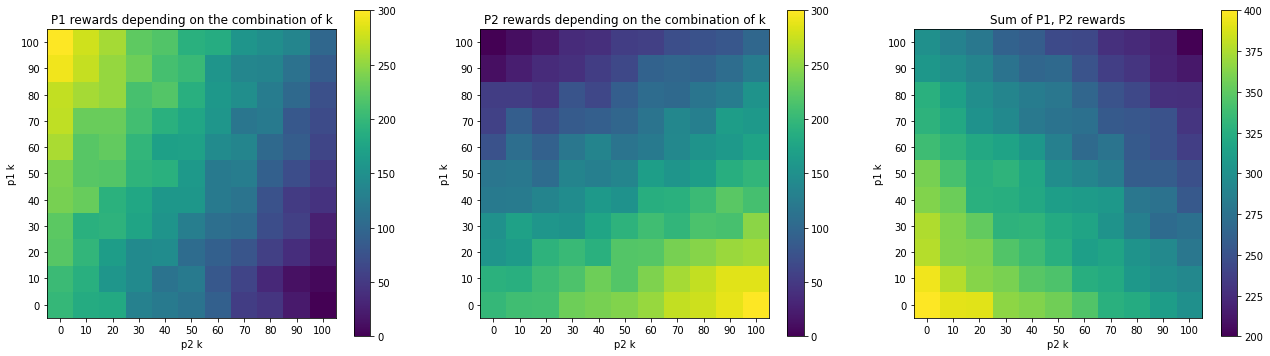

In [12]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

k_p1 = np.arange(0, 101, 10)
k_schedule = np.zeros((121,2))

for i in range(0,121,11):
    k_schedule[i:i+11, 0] = k_p1[i//11]
    k_schedule[i:i+11, 1] = k_p1[:]


reward_history = []
for n in range(np.shape(k_schedule)[0]):
    reward_game = [0,0]
    p1 = KBadGuy(k_schedule[n,0])
    p2 = KBadGuy(k_schedule[n,1])
    for i in range(100):              
        u1 = p1.move()
        u2 = p2.move()

        reward1 = np.array(u1) @ M @ np.array(u2).T
        reward2 = np.array(u2) @ M @ np.array(u1).T
        p1.append_reward(reward1)
        p2.append_reward(reward2)
        
        reward_game[0] += reward1
        reward_game[1] += reward2
        
    reward_history.append(reward_game)
    
reward_history = np.asarray(reward_history)
reward_2d = np.reshape(reward_history, (11,11,2))

# visualization    
# fig, ax = plt.subplots(1,2, figsize = (15,6))
# ax[0].plot(reward_history[:,0], label=("p1"))
# ax[0].plot(reward_history[:,1], label=("p2"))
# ax[0].legend()
# ax[0].grid(linestyle=":")
# ax[0].set_title("final rewards for the combinations of k")
# ax[1].plot(np.sum(reward_history,1), label=("p1"))
# ax[1].grid(linestyle=":")
# ax[1].set_title("Sum of the final reward for both players")


fig, ax = plt.subplots(1,3, figsize = (22,6))
im0 = ax[0].imshow(reward_2d[:,:,0], origin='lower')
ax[0].set_xticks(range(11))
ax[0].set_yticks(range(11))
ax[0].set_xticklabels(range(0,110,10))
ax[0].set_yticklabels(range(0,110,10))
ax[0].set_xlabel("p2 k")
ax[0].set_ylabel("p1 k")
ax[0].set_title("P1 rewards depending on the combination of k")
plt.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(reward_2d[:,:,1], origin='lower')
ax[1].set_xticks(range(11))
ax[1].set_yticks(range(11))
ax[1].set_xticklabels(range(0,110,10))
ax[1].set_yticklabels(range(0,110,10))
ax[1].set_xlabel("p2 k")
ax[1].set_ylabel("p1 k")
ax[1].set_title("P2 rewards depending on the combination of k")
plt.colorbar(im1, ax=ax[1])

im2 = ax[2].imshow(np.sum(reward_2d, 2), origin='lower')
ax[2].set_xticks(range(11))
ax[2].set_yticks(range(11))
ax[2].set_xticklabels(range(0,110,10))
ax[2].set_yticklabels(range(0,110,10))
ax[2].set_xlabel("p2 k")
ax[2].set_ylabel("p1 k")
ax[2].set_title("Sum of P1, P2 rewards")
plt.colorbar(im2, ax=ax[2])

plt.show()

## Introducing the LookBack Player

The LookBack Player uses the past rewards to choose the best strategy in its next move. It compute the summtion of the rewards obtained for every move and it chooses the one with the higher rewards. During the first move, or when the rewards are equal, it chooses randomly. 

We can use a bias that is added to rewards while computing the move decision. This is necessary because with a payoff matrix that has average greater than zero, the LookBack Player tends to simply choose the same move that it has already used from the beginning of the game. So using a bias that is equal to the negative average of the payoff matrix the player decision is not skewed towards the move it has performed more frequently.

We want to see how the LookBack Player performs against a KBadGuy and also if it is able to adopt a cooperative behaviour that maximizes the group reward.

In the following game we see that the LookBack Player tends to win against a MainlyNiceGuy, but we will generalize the behaviour against a KBadGuy later.

KBadGuy final reward 14
LookBackPlayer final reward 122


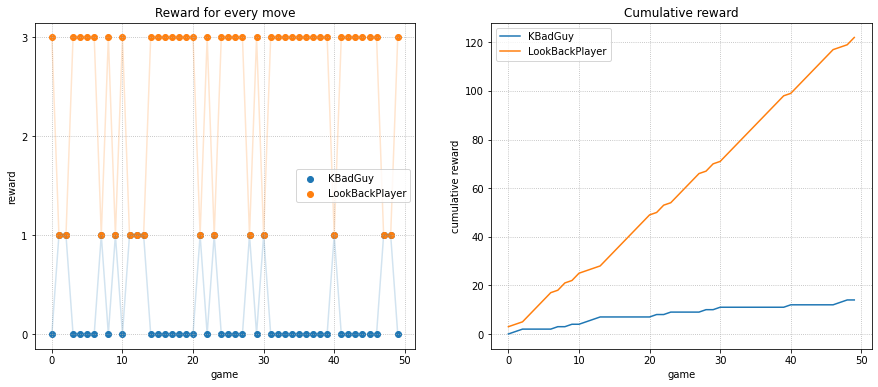

In [13]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

p1 = KBadGuy(40)
p2 = LookBackPlayer(-1.5)

for i in range(50):
    u1 = p1.move()
    u2 = p2.move()
    
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)
    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=(type(p1).__name__),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=(type(p2).__name__),)
ax[0].legend()
ax[0].grid(linestyle=":")
ax[0].set_yticks(range(0,4))
ax[0].set_xlabel("game")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every move")

ax[1].plot(np.cumsum(p1.r_history), label=(type(p1).__name__))
ax[1].plot(np.cumsum(p2.r_history), label=(type(p2).__name__))
ax[1].legend()
ax[1].set_xlabel("game")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")

print(f"{type(p1).__name__} final reward {sum(p1.r_history)}")
print(f"{type(p2).__name__} final reward {sum(p2.r_history)}")

### LookBack Player vs LookBack Player
It is interesting to test the performances of a LooKBack Player against another LookBackPlayer. In this case, after few moves, they adopt a cooperative behaviour that maximizes the group reward.

LookBackPlayer1 final reward 193
LookBackPlayer2 final reward 193


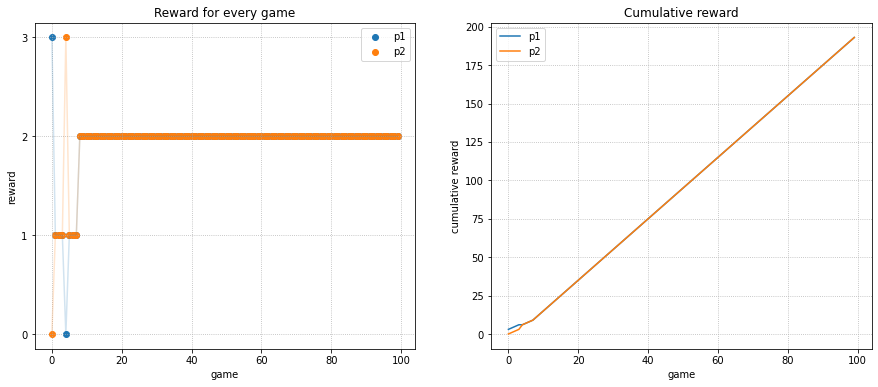

In [14]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

p1 = LookBackPlayer(-1.5)
p2 = LookBackPlayer(-1.5)

for i in range(100):
    u1 = p1.move()
    u2 = p2.move()
    
    p1.append_reward(np.array(u1) @ M @ np.array(u2).T)
    p2.append_reward(np.array(u2) @ M @ np.array(u1).T)

    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(p1.r_history, alpha=0.2)
ax[0].scatter(range(len(p1.r_history)), p1.r_history, label=("p1"),)
ax[0].plot(p2.r_history, alpha=0.2)
ax[0].scatter(range(len(p2.r_history)), p2.r_history,  label=("p2"),)
ax[0].legend()
ax[0].grid(linestyle=":")
ax[0].set_yticks(range(0,4))
ax[0].set_xlabel("game")
ax[0].set_ylabel("reward")
ax[0].set_title("Reward for every game")

ax[1].plot(np.cumsum(p1.r_history), label=("p1"))
ax[1].plot(np.cumsum(p2.r_history), label=("p2"))
ax[1].legend()
ax[1].set_xlabel("game")
ax[1].set_ylabel("cumulative reward")
ax[1].set_title("Cumulative reward")
ax[1].grid(linestyle=":")

print(f"{type(p1).__name__}1 final reward {sum(p1.r_history)}")
print(f"{type(p2).__name__}2 final reward {sum(p2.r_history)}")

### LookBack player against every k bad player
We want to test the LookBackPlayer performances against every KBadGuy. The LookBack Player it is able to win against every KBadGuy that has a *k* parameter lower than circa *k*=85.  
As before, we see that the group reward is higher when the KBadGuy has a more cooperative behaviour.


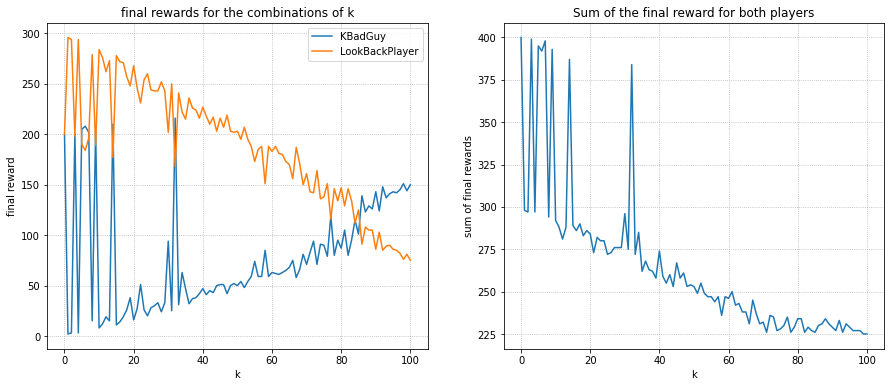

In [15]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

k_p1 = np.arange(0, 101, 10)
k_schedule = np.arange(101)

reward_history = []
for n in range(np.shape(k_schedule)[0]):
    reward_game = [0,0]
    p1 = KBadGuy(k_schedule[n])
    p2 = LookBackPlayer(-1.5)
   
    for i in range(100):          
        u1 = p1.move()
        u2 = p2.move()

        reward1 = np.array(u1) @ M @ np.array(u2).T
        reward2 = np.array(u2) @ M @ np.array(u1).T
        p1.append_reward(reward1)
        p2.append_reward(reward2)
        
        reward_game[0] += reward1
        reward_game[1] += reward2
        
    reward_history.append(reward_game)
    
reward_history = np.asarray(reward_history)
# reward_2d = np.reshape(reward_history, (10,10,2))

# visualization    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(reward_history[:,0], label=("KBadGuy"))
ax[0].plot(reward_history[:,1], label=("LookBackPlayer"))
ax[0].legend()
ax[0].grid(linestyle=":")
ax[0].set_title("final rewards for the combinations of k")
ax[0].set_xlabel("k")
ax[0].set_ylabel('final reward')

ax[1].plot(np.sum(reward_history,1), label=("p1"))
ax[1].grid(linestyle=":")
ax[1].set_title("Sum of the final reward for both players")
ax[1].set_xlabel("k")
ax[1].set_ylabel('sum of final rewards')

plt.show()

### LookBack player against every k bad player 
We run the previous game multiple times in order to reduce the effect of the randomness and see more clearly the regularities on the games results. We plot the the average reward on 50 runs of the games, and we mark with a shaded area the standard deviation.



In [16]:
# Payoff matrix
M = np.array([[2,0],[3,1]])

k_p1 = np.arange(0, 101, 10)
k_schedule = np.arange(101)


reward_history = []
std_history =[]

games_per_batch = 50
for n in range(np.shape(k_schedule)[0]):
    reward_game_batch = [0,0]
    std_history_batch = []
    
    for j in range(games_per_batch):
        reward_game = [0,0]
        p1 = KBadGuy(k_schedule[n])
        p2 = LookBackPlayer(-1.5)
        for i in range(100):      
            u1 = p1.move()
            u2 = p2.move()

            reward1 = np.array(u1) @ M @ np.array(u2).T
            reward2 = np.array(u2) @ M @ np.array(u1).T
            p1.append_reward(reward1)
            p2.append_reward(reward2)

            reward_game[0] += reward1
            reward_game[1] += reward2
        
        std_history_batch.append(reward_game)
        reward_game_batch[0] += reward_game[0]
        reward_game_batch[1] += reward_game[1]
    
    std_history.append(std_history_batch)
    reward_history.append(reward_game_batch)

std_history = np.array(std_history)


reward_history = np.asarray(reward_history)/games_per_batch

std = np.std(std_history, axis=1)

std_history_sum = np.sum(std_history, axis=2)
std_sum =np.std(std_history_sum, axis=1)

reward_history_sum = np.sum(reward_history,1)

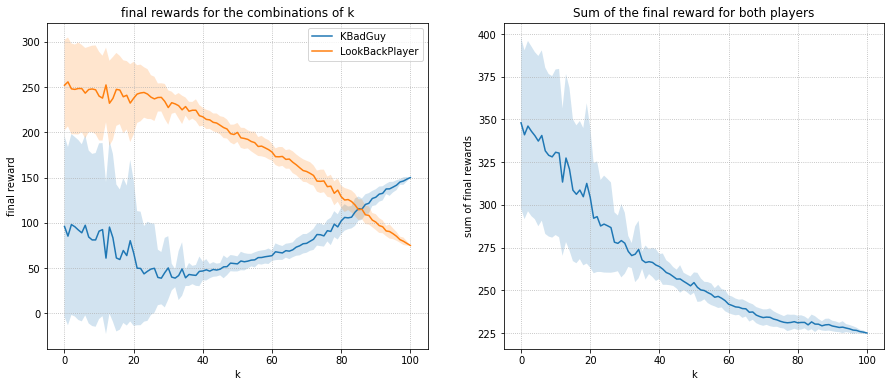

In [17]:
# visualization    
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(reward_history[:,0], label=("KBadGuy"))
ax[0].fill_between(range(np.shape(k_schedule)[0]), reward_history[:,0]+std[:,0],  reward_history[:,0]-std[:,0], alpha=0.2)
ax[0].plot(reward_history[:,1], label=("LookBackPlayer"))
ax[0].fill_between(range(np.shape(k_schedule)[0]), reward_history[:,1]+std[:,1],  reward_history[:,1]-std[:,1], alpha=0.2)
ax[0].legend()
ax[0].grid(linestyle=":")
ax[0].set_title("final rewards for the combinations of k")
ax[0].set_xlabel("k")
ax[0].set_ylabel('final reward')

ax[1].plot(reward_history_sum, label=("p1"))
ax[1].fill_between(range(np.shape(k_schedule)[0]), reward_history_sum+std_sum,  reward_history_sum-std_sum, alpha=0.2)
ax[1].grid(linestyle=":")
ax[1].set_title("Sum of the final reward for both players")
ax[1].set_xlabel("k")
ax[1].set_ylabel('sum of final rewards')

plt.show()

# Part 2: multiplayer IPD


In order to extend our game to a N-Players scenario, we started from the normal form matrix proposed in [1]:
<br><br>
$$
\begin{gather*}
    \text{Number of cooperators among the remaining $n-1$ players}\\
    \text{Player $i$}
    \begin{pmatrix}
        0 & 2 & 4 & \textbf{...} & 2(n-1)\\
        1 & 3 & 5 & \textbf{...} & 2(n-1)+1\\
    \end{pmatrix}
\end{gather*}\\
$$
<br>
Where in the first row we have the player payoffs when he chooses to collaborate, and in the second one the payoffs when he decides to defect.

Thanks to this new payoff matrix, we can simply compute the i-th player payoff as:
<br><br>
$$
u_{i} =
\begin{cases}
    2(n_c-1)\quad\text{if player $i$ is collaborating}\\
    2n_c+1\quad\text{if player $i$ is defecting}
\end{cases}
$$<br>
where $n_c$ is the number of cooperators among the $n$ players.<br>
Thanks to this game formulation, we can easly compute the average per-round payoff $a$:<br><br>
$$
a = 1 + \frac{N_c}{N}(2N-3)
$$
<br>
where:
$$
\begin{cases}
    N_c = \text{number of collaborating players}\\
    N = \text{number of players in the game}
\end{cases}
$$


References:<br>
[1]: https://link.springer.com/chapter/10.1007/3-540-60154-6_50

In [4]:
def calc_reward(Nc, c):
    if(c == 0): #not collaborating
        return 2*(Nc)+1
    
    else:
        return 2*(Nc-1)


#P_list = player list
#GI = number of Game Iterations
def MPIPD(P_list, GI):
    # game loop
    for i in range(GI):

        U = np.array([P_list[i].move() for i in range(len(P_list))]).T #matrix with all the players move of this round
        Nc = np.sum(U[0,:])#number of collaborating players
        
        for k in range(len(P_list)):   #for each player    
            
            
            #Calculate rewards
            P_list[k].append_reward(calc_reward(Nc, U[0, k]))
            

            #check if player is tit4tat, if yes, update input history
            if(isinstance(P_list[k], Tit4Tat)):

                if(Nc > np.ceil(len(P))/2): #at lest 50% are collaborating
                    P_list[k].append_input([1,0])

                else: #less than 50% are collaborating                
                    P_list[k].append_input([0,1])
                    
            if(isinstance(P_list[k], Tit4TatMP) or isinstance(P_list[k], GrimTriggerMP)):
                P_list[k].append_input(np.delete(U, k, axis=1).T)

            


#P_list = player list
#P_plot_index = indexes of the player that we want to plot
def plot_rewards_MPIPD(P_list, P_plot_index=None):        

    if(P_plot_index == None): 
        P_plot_index = range(len(P_list))
        
        
    fig, ax = plt.subplots(1,2, figsize = (15,6))

    for i in P_plot_index:

        print("player"+ str(i) +" final reward "+ str(sum(P_list[i].r_history)) +". Player type: " + str(type(P_list[i]).__name__))
        ax[0].scatter(range(len(P_list[i].r_history)),P_list[i].r_history, alpha=0.7, marker=".", s=300)
        ax[0].plot(P_list[i].r_history, alpha=0.2)
        ax[0].grid(linestyle=":")
        ax[0].set_xlabel("game")
        ax[0].set_ylabel("reward")
        ax[0].set_title("Reward for every game")
        
        
        ax[1].plot(np.cumsum(P_list[i].r_history), label=str(type(P_list[i]).__name__))
        ax[1].legend()
        ax[1].grid(linestyle=":")
        ax[1].set_xlabel("game")
        ax[1].set_ylabel("cumulative reward")
        ax[1].set_title("Cumulative reward")

player0 final reward 238. Player type: Tit4Tat
player1 final reward 235. Player type: KBadGuy
player2 final reward 190. Player type: NiceGuy
player3 final reward 262. Player type: KBadGuy


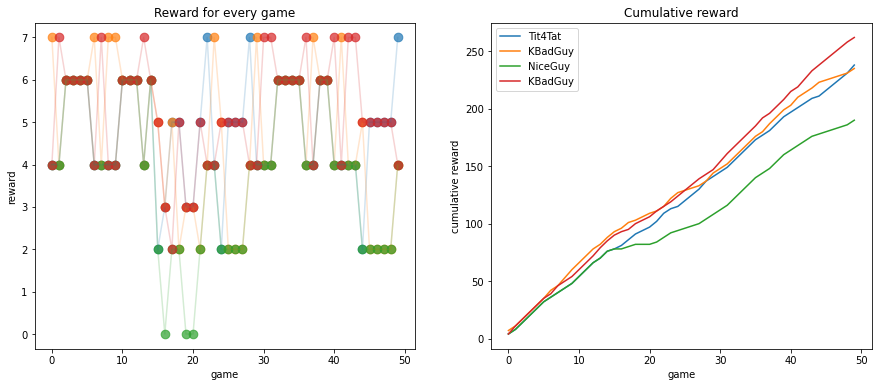

In [19]:
# initialize players instances

p1 = Tit4Tat()
p2 = KBadGuy(40)
p3 = NiceGuy()
p4 = BadGuy()
p5 = KBadGuy(60)

P = [p1, p2, p3, p5]

#run the game
MPIPD(P, 50)

#plot the results
plot_rewards_MPIPD(P)

plt.show()

player0 final reward 234. Player type: Tit4TatMP
player4 final reward 231. Player type: GrimTriggerMP
player5 final reward 174. Player type: LookBackPlayer


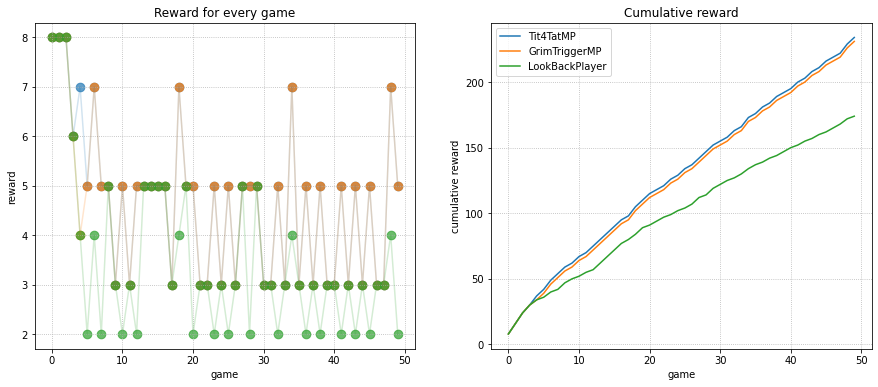

In [20]:
p1 = Tit4TatMP(0.7)
p2 = KBadGuy(60)
p3 = NiceGuy()
p4 = BadGuy()
p5 = GrimTriggerMP(0.4)
p6 = LookBackPlayer(-5.5)

P = [p1, p2, p3, p4, p5, p6]

MPIPD(P, 50)
plot_rewards_MPIPD(P,[0,4,5])

plt.show()

# Part 3: reapeted multiplayer IPD with population increasing
Iterate what done in the previous task (repeated MPIPD, rMPIPD)  by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration

## ```rMPIPD```
Function that takes as input an initial list of players and let them play in a ```MPIPD``` for a number of iterations specified as input (100 as default). The function then adds a player whose type will be chosen among the others who have already played according some criteria given as input. There is a macro criterium, which can be one of the following:
<ul>
    <li> Player who achieved maximum final reward </li>
    <li> Randomly </li>
    <li> Player who gained minimum final reward </li>
</ul>
and a "micro" criterium, i.e, a criterium that is used in case there is a tie between player's payoff, which can happen using the first and third macro criterium (max and min). The 3 micro criteria are the following
<ul>
    <li> Highest number of cooperations </li>
    <li> Randomly </li>
    <li> Highest number of defections </li>
</ul>
From this logic it comes the name of the criteria put as input to the <code>rMPIPD</code> function, like for example <code>max_r</code> ( which is also the default in the function), which shows that it is used the max as macro criterium, and random as micro criterium.
The procedure is then repeated for a number of repetitions, called tournaments, given as input (20 as default).
Finally, the function creates two graphs: one that compares the mean final payoff per tournament of the type of players involved normalized with respect to the maximum time by time and which player was added and one concerning the mean rewards and their deviations of the types of the players along the different tournaments.

In [5]:
'''
    Function called by the successive one. It is given as input a list made of players of the same type.
    The function returns the mean number of moves of the type given as input done by the players considered.
'''
def mean_moves(player_list, type_move):
    move_sum = 0
    if type_move == "c":
        for player in player_list:
            history = np.array(player.move_history)
            move_sum += history[history==np.array([1,0])].size
    elif type_move == "d":
        for player in player_list:
            history = np.array(player.move_history)
            move_sum += history[history==np.array([0,1])].size
    mean = move_sum/len(player_list)
    return mean

'''
    Function that implements the non random micro criteria. It is given as input the list of players selected
    through the macro criterium, computes the mean number of moves of the type given as input for every category of player
    and outputs the index to be used to add the new player.
'''
def max_move_indexes(player_list, selected_lb, index, type_move):
    labels = np.array(list(map(lambda x: x.label, player_list)))
    coop_means = np.zeros(len(selected_lb))
    for h in range(len(selected_lb)):
        coop_means[h] = mean_moves(list(compress(player_list, labels==selected_lb[h])), type_move)
    res = np.where(coop_means==max(coop_means))[0]
    if res.size == 0:
        selecting_index = res
    else:
#         If still after using the micro criterium the choice would be multiple, randomize between these last selection
        selecting_index = index[np.random.choice(res)]
    return selecting_index


'''
    Main function which takes as input the initial list of players, let them play in an MPIPD game, and then adds a new player
    following the criterium given as input. The procedure is repeated for the number of times "rep_num".
    The function then plots the 2 graphs concerning the players added tournament by tournament and the mean reward trend.
'''
def rMPIPD(P_list, criterium = "max_r", rep_num=20, iter_num=100):

    num_p = len(P_list)
    input_labels = list(map(lambda x: x.label, P_list))
    winners = pd.DataFrame(columns = range(1,rep_num+1), index = input_labels)
    tournaments_rewards = []
    
    for j in range(rep_num):
#         Reset the player's histories and update LookBackPlayer bias after every player addition
        for player in P_list:
            player.p_reset()
            if type(player).__name__ == "LookBackPlayer":
                player.bias = -1*(len(P_list)-0.5)
                
#         Run the game
        MPIPD(P_list, iter_num)
        
#         Find mean reward and deviation and store in a DataFrame for later use
#         Retrieve also the labels
        rewards = np.array([np.sum(P_list[i].r_history) for i in range(len(P_list))])
        labels = np.array(list(map(lambda x: x.label, P_list)))
        reward_df = pd.DataFrame({"reward": rewards},index=labels)
        rew_list = []
        
        for lab in input_labels:
            lab_reward = np.array(reward_df.loc[lab,"reward"])
            mean = np.sum(lab_reward)/lab_reward.size
            std = np.sqrt(np.sum((lab_reward-mean)**2)/lab_reward.size)
            rew_list.append([mean,std])
        
        rew_statistichs = pd.DataFrame(rew_list,columns=('mean','std'),index=input_labels)
        tournaments_rewards.append(rew_statistichs)
        i = np.where(np.array(rew_statistichs.loc[:,'mean'])==max(rew_statistichs.loc[:,'mean']))[0]
        winners_lab = [input_labels[k] for k in i]
        winners.iloc[i,j] += 1
        
#         Understand how the new person should play
        if "max" in criterium:
            i = np.where(rewards==max(rewards))[0]
            if i.size > 1:
                if criterium == "max_r":
                    i = i[np.random.randint(0,i.size)]
                elif criterium == "max_c":
                        i = max_move_indexes(P_list,winners_lab,i,"c")
                elif criterium == "max_d":
                        i = max_move_indexes(P_list,winners_lab,i,"d")
            else:
                i = int(i)

        elif criterium=="random":
            i = np.random.randint(num_p)
            
        elif "min" in criterium:
            i = np.where(np.array(rew_statistichs.loc[:,'mean'])==min(rew_statistichs.loc[:,'mean']))[0]
            loser_labs = [input_labels[k] for k in i]
            if i.size > 1:
                if criterium == "min_r":
                    i = i[np.random.randint(0,i.size)]
                elif criterium == "min_c":
                        i = max_move_indexes(P_list,loser_labs,i,"c")
                elif criterium == "min_d":
                        i = max_move_indexes(P_list,loser_labs,i,"d")
            else:
                i = int(i)

#         Assign the type to the new person joining the game
        new_p = copy.deepcopy(P_list[i])
        P_list.append(new_p)           
#---------------------------------------------------------------


#     Retrieve data for the plots and the print
    win_data = np.where(winners!=0)
    u = np.unique(win_data[0])
    added_labels = np.array(list(map(lambda x: x.label, P_list[num_p:])))
    u = np.unique(added_labels)
    added_data = []
    for i in range(added_labels.size):
        j = 0
        while added_labels[i]!=input_labels[j]:
            j += 1
        added_data.append(j)
    
    p_rewards_norm = np.empty((num_p,rep_num))
    for i in range(rep_num):
        p_rewards_norm[:,i] = np.array(tournaments_rewards[i].loc[:,'mean'])/np.max(np.array(tournaments_rewards[i].loc[:,'mean']))

#     Create first graph concerning the added players
    fig, ax = plt.subplots(1,2, figsize=(16,6))
    fig.suptitle('Analysis on rMPIPD with criterium $' + criterium + '$', fontsize=30, y=1)
    im = ax[0].imshow(p_rewards_norm, origin="lower", aspect='auto', cmap="cividis")
    ax[0].scatter(range(rep_num), added_data, marker='x', s=100, facecolors='r', edgecolors='r', label="Added")
    ax[0].set_yticks(range(num_p))
    ax[0].set_yticklabels(input_labels)
    ax[0].legend()
    ax[0].set_xticks(range(0,rep_num,2))
    ax[0].set_ylabel("Player")
    ax[0].set_xlabel("Tournament number")
    ax[0].set_title("Mean normalized reward and additions", fontsize=13)
    plt.colorbar(im, ax=ax[0])

    
#     Create second graph concerning the reward trend
    for lab in input_labels:
        mean = np.array([])
        std = np.array([])
        for it in range(rep_num):
            mean = np.append(mean,tournaments_rewards[it].loc[lab,"mean"])
            std = np.append(std,tournaments_rewards[it].loc[lab,"std"])
        ax[1].plot(mean,label=lab, linestyle='-', marker='o')
        ax[1].fill_between(range(rep_num),mean-std,mean+std,alpha=0.3)
    ax[1].legend(bbox_to_anchor=(1.05,1))
    ax[1].grid(linestyle=":")
    ax[1].set_xticks(range(0,rep_num,2))
    ax[1].set_ylabel("Payoff")
    ax[1].set_xlabel("Tournament number")
    ax[1].set_title("Mean player payoff trend and deviations")
    plt.show()
    
#     Print the number of added players
    print("Number of players added")
    for j in range(0,u.size):
        print(u[j] + " : " + str(added_labels[added_labels==u[j]].size))

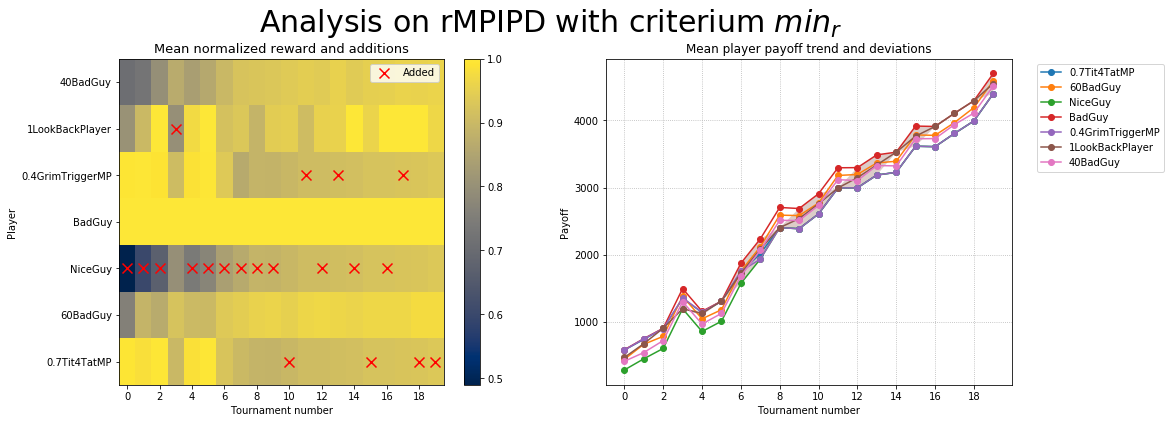

Number of players added
0.4GrimTriggerMP : 3
0.7Tit4TatMP : 4
1LookBackPlayer : 1
NiceGuy : 12


In [6]:
p1 = Tit4TatMP(0.7)
p2 = KBadGuy(60)
p3 = NiceGuy()
p4 = BadGuy()
p5 = GrimTriggerMP(0.4)
p6 = LookBackPlayer(-1.5)
p7 = KBadGuy(40)

P = [p1, p2, p3, p4, p5, p6, p7]

rMPIPD(P,"min_r")

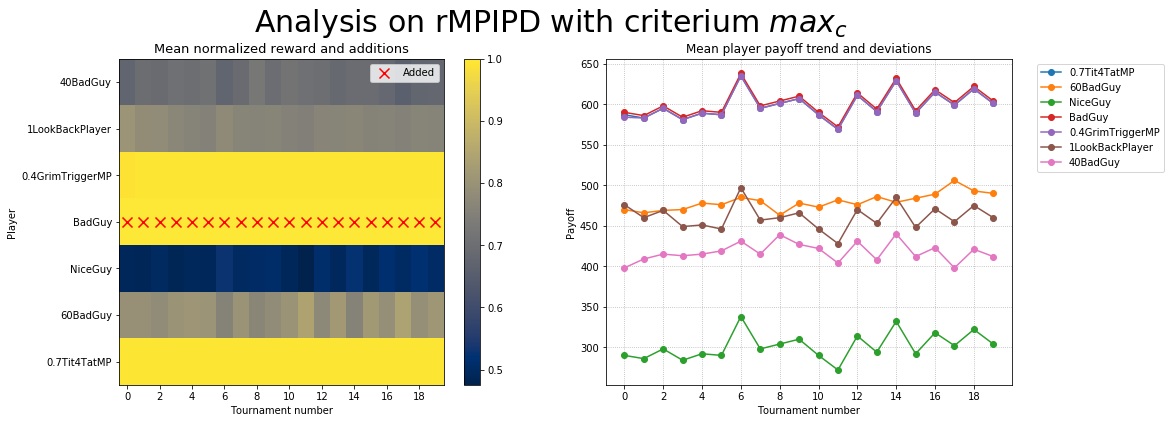

Number of players added
BadGuy : 20


In [7]:
p1 = Tit4TatMP(0.7)
p2 = KBadGuy(60)
p3 = NiceGuy()
p4 = BadGuy()
p5 = GrimTriggerMP(0.4)
p6 = LookBackPlayer(-1.5)
p7 = KBadGuy(40)

P = [p1, p2, p3, p4, p5, p6, p7]

rMPIPD(P,"max_c")

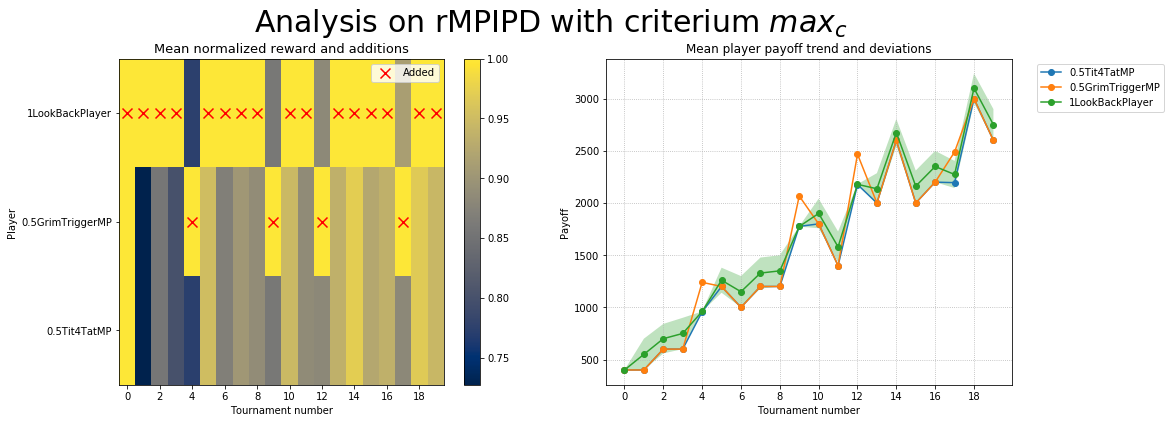

Number of players added
0.5GrimTriggerMP : 4
1LookBackPlayer : 16


In [8]:
p1 = Tit4TatMP(0.5)
p2 = GrimTriggerMP(0.5)
p3 = LookBackPlayer(-1.5, delta=1)

P = [p1,p2,p3]

rMPIPD(P,"max_c")

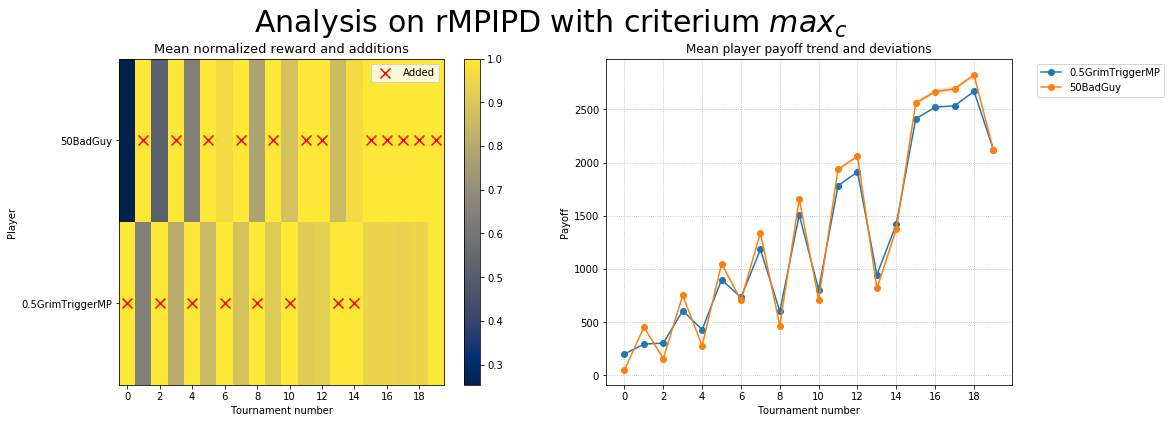

Number of players added
0.5GrimTriggerMP : 8
50BadGuy : 12


In [26]:
p1 = GrimTriggerMP(0.5)
p2 = KBadGuy(50)

P = [p1,p2]

rMPIPD(P,"max_c")

# Part4: rMPIPD with mutating strategies
(*difficult*) Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natura selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined. 

For this task we explore the idea of players that can generate *children* similar to them and *die* if their rewards are not good enough.

Import graphic packages for the graph plots

In [21]:
from matplotlib.lines import Line2D

try:
    import networkx as nx
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    print("graphviz_layout not installed")

### Extend KBadGuy 
We need to extend the KBadGuy player adding an identifier property ID, and information about its relation with the other players.

In [22]:
class KBadGuy2(KBadGuy):
    color_alive = "#1f77b4"
    color_dead = "#8FBBD9"
    
    def __init__(self, k, family=[], r_history=[], move_history=[], ID=None):
        KBadGuy.__init__(self, k, r_history=r_history, move_history=move_history)
        self.ID = ID
        self.family = copy.deepcopy(family)


## Define the evolvingMPIPD function
We define a function that uses MPIPD and takes care of the generation of new players and controls the population size by deleting the player with lower rewards.

In [23]:
class IDSupplier:
    """
    class that returns incremental unique IDs
    """

    def __init__(self):
        self.count = 0

    def new_id(self):
        id = self.count
        self.count += 1
        return id

legend = [ 
    Line2D([0], [0], marker="o", color="w", label="Alive", markerfacecolor=KBadGuy2.color_alive, markersize=15),
    Line2D([0], [0], marker="o", color="w", label="Dead", markerfacecolor=KBadGuy2.color_dead, markersize=15)
] 
    
# P_list = player list
def evolvingMPIPD(
    P_list,
    num_epochs,
    GI,
    control_population,
    children=1,
    delta_range=10,
    display_graph=False,
):
    """
    parameters:
        P_list (list): initial players instances.
        num_epochs (int): number of epochs performed.
        GI (int): game iterations inside a epoch.
        control_population (int): maximum number of players that can be active
            during an epoch.
    Return:
        it modifies the input P_list
        G: directed graph networkx
        all_k_history: list of all k for each epoch
    """
    G = nx.DiGraph()

    all_k_history = []
    
    id_sup = IDSupplier()
    for i, player in enumerate(P_list):
        player.ID = id_sup.new_id()
        G.add_node(player.ID, color=player.color_alive)

    if display_graph:
        fig, ax = plt.subplots(figsize=(24, 11))
        ax.legend(handles=legend)  

    for epoch in range(num_epochs):
        
        all_k = []
        
        # reset the reward history
        for player in P_list:
            player.p_reset()

        # call a game loop
        MPIPD(P_list, GI)

        def key_r(player):
            return sum(player.r_history)

        # sort the player list inplace
        P_list.sort(reverse=True, key=key_r)

        # kill the player with small rewards and keep population stable
        while len(P_list) > control_population:
            dead_player = P_list.pop()
            colors = nx.get_node_attributes(G, "color")
            colors[dead_player.ID] = player.color_dead
            nx.set_node_attributes(G, colors, "color")

        # remaining players make new children
        current_P = len(P_list)
        
        for player in P_list[0:current_P]:
            for i in range(children):
                son = KBadGuy2(
                    k = np.clip(
                        player.k + np.random.uniform(-delta_range, delta_range), 0, 100
                    ),
                    ID = id_sup.new_id(),
                )
                # add son ID to the parent family
                player.family.append(son.ID)
                
                G.add_node(son.ID, color=son.color_alive)
                G.add_edge(player.ID, son.ID)
                P_list.append(son)

        if display_graph:
            plt.title("Generation graph")
            pos = graphviz_layout(G, prog="dot")
            nx.draw(
                G,
                pos,
                node_color=nx.get_node_attributes(G, "color").values(),
                with_labels=False,
                arrows=True,
            )
            display.clear_output(wait=True)
            display.display(plt.gcf())

        for player in P_list:
            all_k.append(player.k)
            
        all_k_history.append(all_k)
        
    if display_graph:
        plt.clf()
    return G, all_k_history

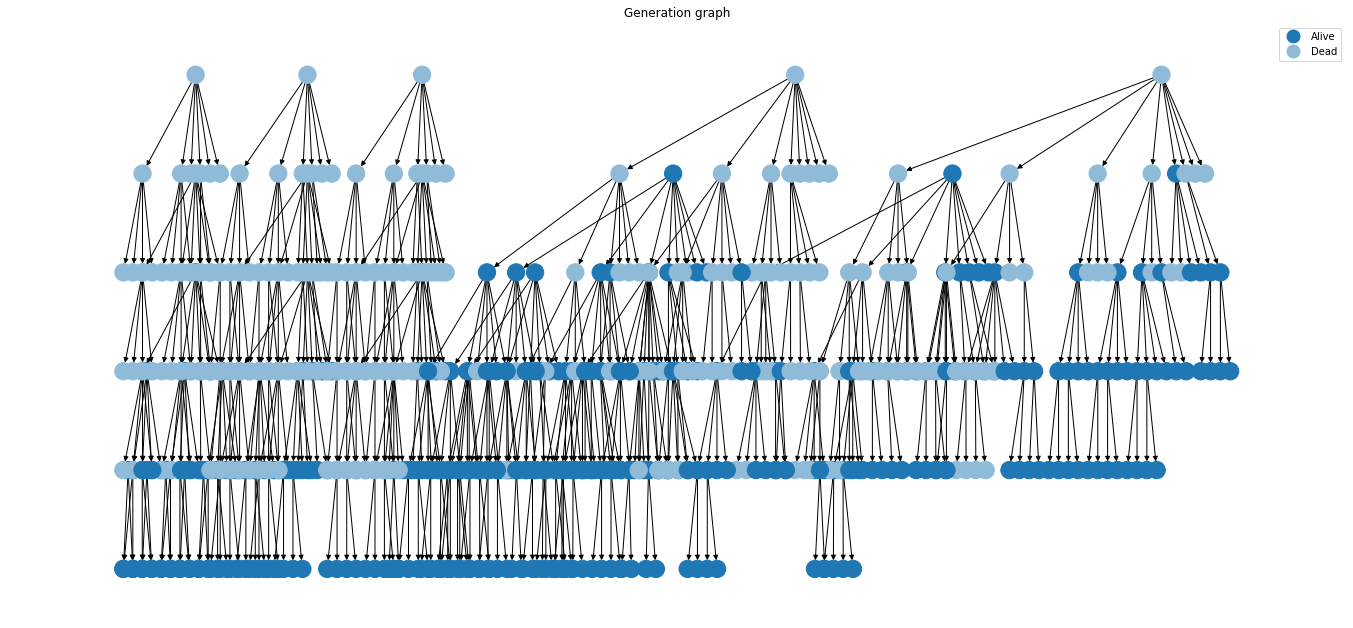

<Figure size 1728x792 with 0 Axes>

In [24]:
P_list = [KBadGuy2(i*10) for i in range(1,6)]


G, all_k_history = evolvingMPIPD(P_list, 5, 30, 40, children=2, display_graph=True)

Show the final graph to visualize dead and alive players over the different generations.

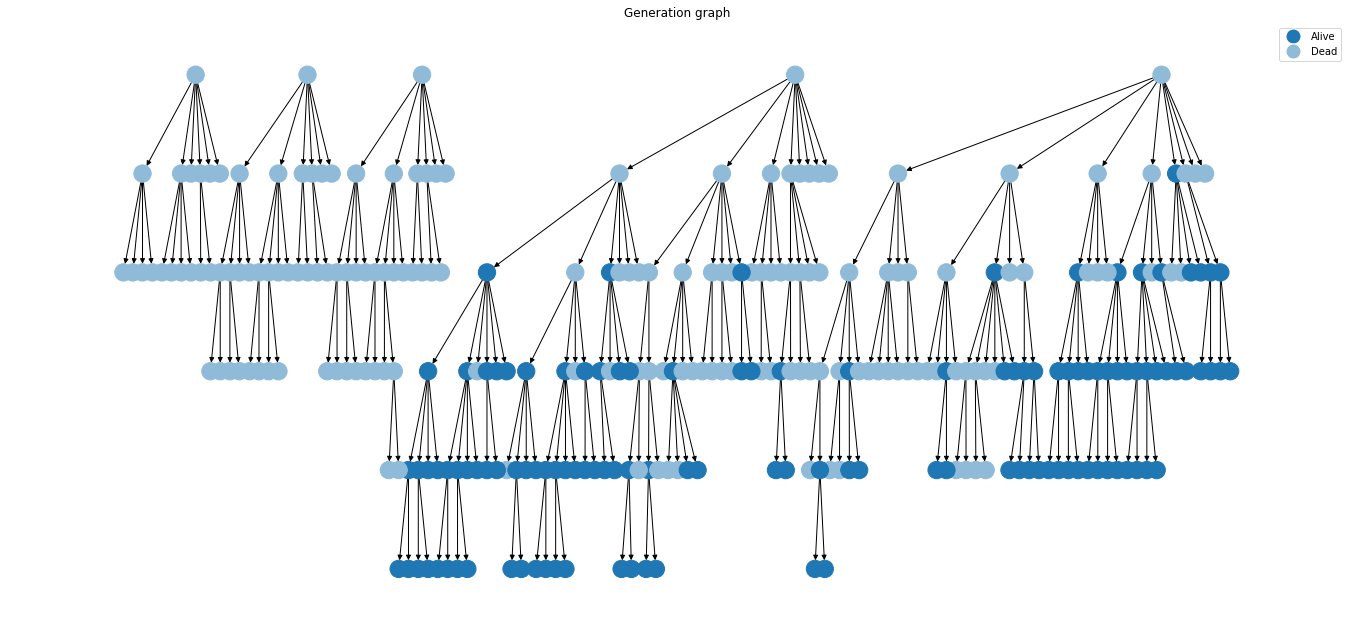

In [25]:
if "graphviz_layout" in dir(nx.drawing.nx_agraph):
    fig, ax = plt.subplots(figsize=(24, 11))
    ax.legend(handles=legend) 
    plt.title("Generation graph")
    pos = graphviz_layout(G, prog="dot")
    nx.draw(
        G,
        pos,
        node_color=nx.get_node_attributes(G, "color").values(),
        with_labels=False,
        arrows=True,
    )

Show the graph with only the surviving players

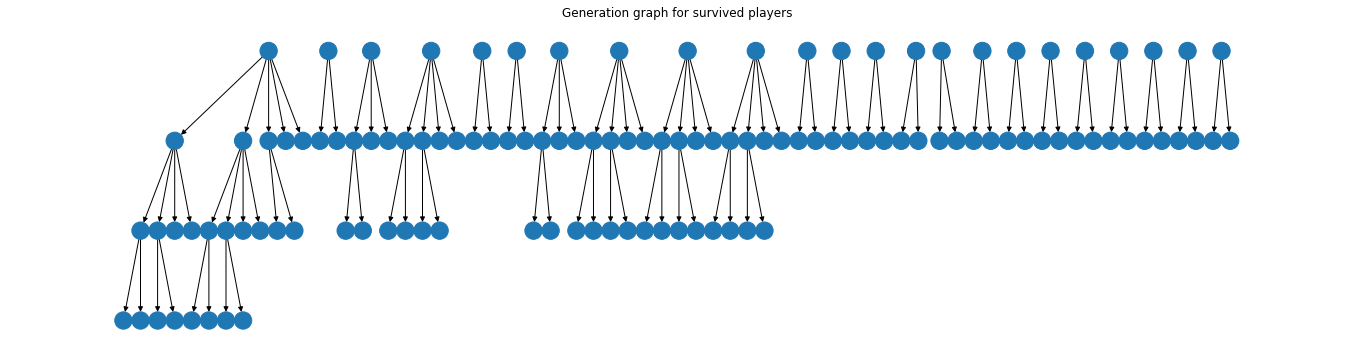

In [27]:
nodes_list = list(G.nodes(data="color"))
for i, color in nodes_list:
    if color == KBadGuy2.color_dead:
        G.remove_node(i)
        
if "graphviz_layout" in dir(nx.drawing.nx_agraph):
    fig, ax = plt.subplots(figsize=(24, 6))
    plt.title("Generation graph for survived players")
    pos = graphviz_layout(G, prog="dot")
    nx.draw(
        G,
        pos,
        node_color=nx.get_node_attributes(G, "color").values(),
        with_labels=False,
        arrows=True,
    )

Run again the evolvingMPIPD function and render an animation that shows the evolution of the *k* values of the players over the epochs.

In [28]:
P_list = [KBadGuy2(i*10) for i in range(1,6)]


G, all_k_history = evolvingMPIPD(P_list, 50, 30, 40, children=2, display_graph=False)

In [29]:
%matplotlib agg
import matplotlib as cm
from celluloid import Camera
from IPython.display import HTML

fig, ax = plt.subplots(2,1)
camera = Camera(fig)
for i, k_frame in enumerate(all_k_history):
    scatter = ax[0].scatter(range(len(k_frame)), k_frame, color="#1f77b4")
    ax[0].legend((scatter,), (f"Epoch {i+1}",))
    ax[0].set_ylabel("k")
    ax[0].set_title("K value variation on each epoch")
    
    n_bins = max(int(np.std(k_frame)),3)
    hist = ax[1].hist(k_frame, bins=n_bins, color='#ff7f0e')
    ax[1].set_xlabel("k")
    ax[1].set_ylabel("frequency of k")
    camera.snap()
    
anim = camera.animate(interval=250)
HTML(anim.to_html5_video())

In [30]:
%matplotlib inline

### Extend other players
We need to add the *ID* and *family* property to the other players in order to implement an evolving MPIPD function that works with every player.

In [31]:
class Tit4TatMP2(Tit4TatMP):
    """
    Player that starts with cooperate and then cooperates only if a fraction of players
    above or equal c_treshold has cooperated.
    """

    color_alive = "#ff7f0e"
    color_dead = "#f7c592"

    def __init__(
        self,
        family=[],
        r_history=[],
        move_history=[],
        input_history=[],
        c_threshold=0.5,
        ID=None,
    ):
        Tit4TatMP.__init__(
            self,
            r_history=r_history,
            move_history=move_history,
            input_history=input_history,
            c_threshold=c_threshold,
        )
        self.ID = ID
        self.family = copy.deepcopy(family)


class GrimTriggerMP2(GrimTriggerMP):
    """
    Player that cooperates until a numbers of players >= d_threshold defect in a turn,
    from now on he defects in every turn.
    Setting d_threshold=0 means that it needs only one defecting player
    to start defecting itself.
    """

    color_alive = "#2ca02c"
    color_dead = "#bcf5b3"

    def __init__(
        self,
        family=[],
        r_history=[],
        move_history=[],
        input_history=[],
        d_threshold=0.5,
        ID=None,
    ):
        GrimTriggerMP.__init__(
            self,
            r_history=r_history,
            move_history=move_history,
            input_history=input_history,
            d_threshold=d_threshold,
        )

        self.ID = ID
        self.family = copy.deepcopy(family)


class LookBackPlayer2(LookBackPlayer):
    """
    Player that use past rewards in order to decide the next move.
    """

    color_alive = "#d62728"
    color_dead = "#ebbec0"

    def __init__(
        self, bias=0, family=[], r_history=[], move_history=[], memory=np.inf, ID=None
    ):
        LookBackPlayer.__init__(
            self, bias, r_history=r_history, move_history=move_history
        )

        self.ID = ID
        self.family = copy.deepcopy(family)

## Define the evolvingMPIPD2 function
We define a variation of the evolvingMPIPD function that works with every player type. In this function the evolving gene is considered as the player type. At every epoch the alive players generate a number of *children* that are players of its type. 

In [32]:
legend_elements = [ 
    Line2D([0], [0], marker="o", color="w", label="KBadGuy2", markerfacecolor=KBadGuy2.color_alive, markersize=15),
    Line2D([0], [0], marker="o", color="w", label="Tit4TatMP2", markerfacecolor=Tit4TatMP2.color_alive, markersize=15),
    Line2D([0], [0], marker="o", color="w", label="GrimTriggerMP2", markerfacecolor=GrimTriggerMP2.color_alive, markersize=15),
    Line2D([0], [0], marker="o", color="w", label="LookBackPlayer2", markerfacecolor=LookBackPlayer2.color_alive, markersize=15)
]


# P_list = player list
def evolvingMPIPD2(
    P_list,
    num_epochs,
    GI,
    control_population,
    children=1,
    delta_range=10,
    display_graph=False,
):
    """
    parameters:
        P_list (list): initial players instances.
        num_epochs (int): number of epochs performed.
        GI (int): game iterations inside a epoch.
        control_population (int): maximum number of players that can be active
            during an epoch.
    Return:
        it modifies the input P_list
        G: directed graph networkx
        players_type_history: list with number of players of each type, for each epoch
    """
    G = nx.DiGraph()
    
    players_type_history = []
    
    id_sup = IDSupplier()
    
    players_type_counter = {
        "KBadGuy2":0,
        "Tit4TatMP2":0,
        "GrimTriggerMP2":0,
        "LookBackPlayer2":0
    } 
    
    for i, player in enumerate(P_list):
        player.ID = id_sup.new_id()
        player_type = type(player).__name__
        players_type_counter[player_type] += 1
        G.add_node(player.ID, color=player.color_alive, player_type=player_type)
        
    
    if display_graph:
        fig, ax = plt.subplots(figsize=(24, 11))
        ax.legend(handles=legend_elements)  

    for epoch in range(num_epochs):
        # reset the reward history
        for player in P_list:
            player.p_reset()
            # adapt the bias of the Lookback player
            # so the biased payoff matrix has zero mean
            if type(player).__name__ == "LookBackPlayer2":
                player.bias = -1*(len(P_list)-0.5)

        # call a game loop
        MPIPD(P_list, GI)

        def key_r(player):
            return sum(player.r_history)

        # sort the player list inplace
        P_list.sort(reverse=True, key=key_r)

        # kill the player with small rewards and keep population stable
        while len(P_list) > control_population:
            dead_player = P_list.pop()
            colors = nx.get_node_attributes(G, "color")
            player_type = type(dead_player).__name__
            
            colors[dead_player.ID] = dead_player.color_dead
            nx.set_node_attributes(G, colors, "color")
            players_type_counter[player_type] -= 1

        # remaining players make new children
        current_P = len(P_list)

        for player in P_list[0:current_P]:

            player_type = type(player).__name__
            for i in range(children):

                if player_type == "KBadGuy2":
                    son = KBadGuy2(
                        k=player.k,
                        family=player.family,
                        ID=id_sup.new_id(),
                    )
                elif player_type == "Tit4TatMP2":
                    son = Tit4TatMP2(
                        family=player.family,
                        c_threshold=player.c_threshold,
                        ID=id_sup.new_id(),
                    )

                elif player_type == "GrimTriggerMP2":
                    son = GrimTriggerMP2(
                        family=player.family,
                        d_threshold=player.d_threshold,
                        ID=id_sup.new_id(),
                    )
                elif player_type == "LookBackPlayer2":
                    son = LookBackPlayer2(
                        bias=player.bias,
                        family=player.family,
                        ID=id_sup.new_id(),
                    )
                
                players_type_counter[player_type] += 1
    
                # add son ID to the parent family
                player.family.append(son.ID)
                
                G.add_node(son.ID, color=son.color_alive, player_type=player_type)
                G.add_edge(player.ID, son.ID)
                P_list.append(son)
                
        if display_graph:
            plt.title("Generation graph")
            pos = graphviz_layout(G, prog="dot")
            nx.draw(
                G,
                pos,
                node_color=nx.get_node_attributes(G, "color").values(),
                with_labels=False,
                labels=nx.get_node_attributes(G, "player_type"),
                arrows=True,
            )
            display.clear_output(wait=True)
            display.display(plt.gcf())

        players_type_history.append(copy.deepcopy(players_type_counter))
        
    if display_graph:
        plt.clf()
        

    return G, players_type_history

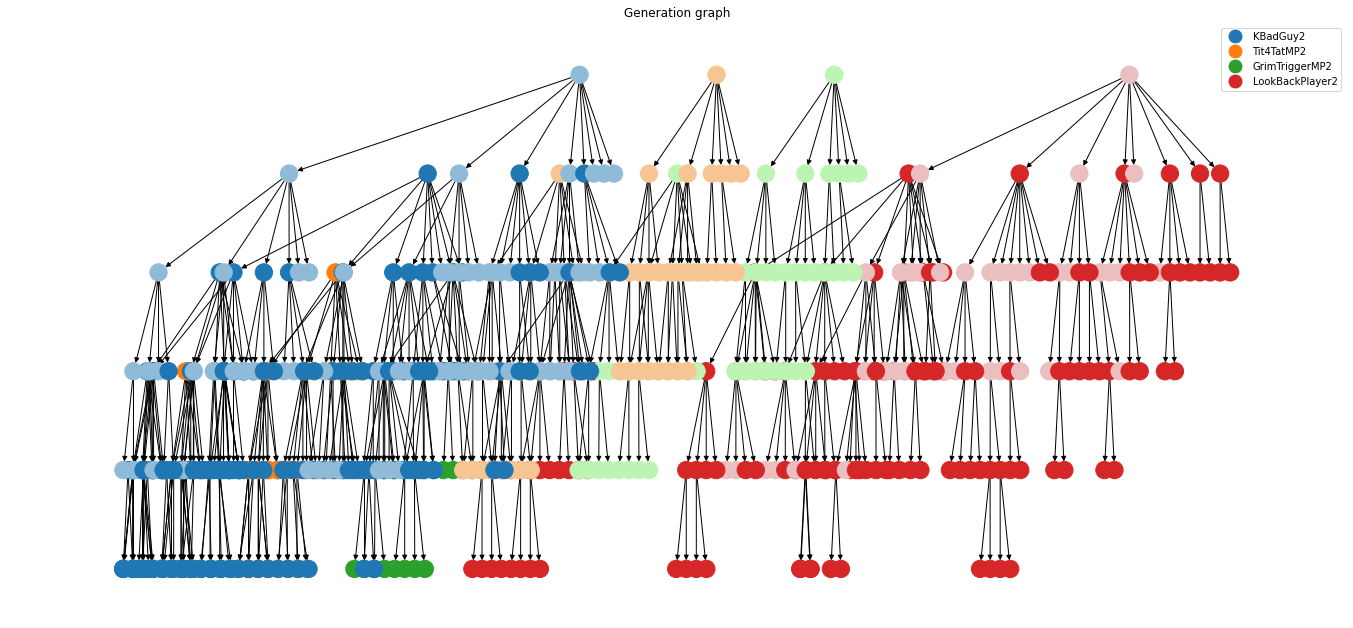

<Figure size 1728x792 with 0 Axes>

In [33]:
P_list = [
    KBadGuy2(10),
    Tit4TatMP2(c_threshold=0.5),
    GrimTriggerMP2(d_threshold=0.5),
    LookBackPlayer2(bias=0),
]
# used later to delete dead players from graph
dead_colors = [player.color_dead for player in P_list]


G, players_type_history = evolvingMPIPD2(P_list, 5, 30, 40, children=2, display_graph=True)

Show the generations graph with colors that characterize every player type. Lighter colors indicate dead players.

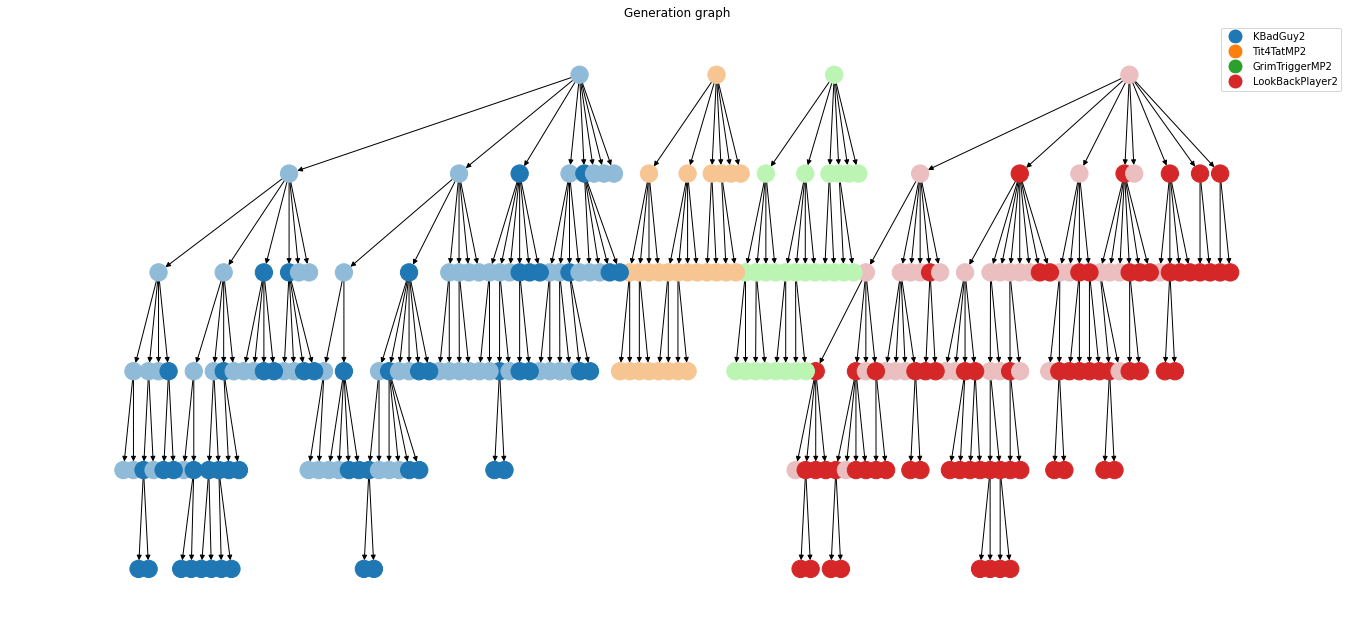

In [34]:
if "graphviz_layout" in dir(nx.drawing.nx_agraph):
    fig, ax = plt.subplots(figsize=(24, 11))
    ax.legend(handles=legend_elements)
    plt.title("Generation graph")
    pos = graphviz_layout(G, prog="dot")
    nx.draw(
        G,
        pos,
        node_color=nx.get_node_attributes(G, "color").values(),
        with_labels=False,
        labels=nx.get_node_attributes(G, "player_type"),
        arrows=True,
    )

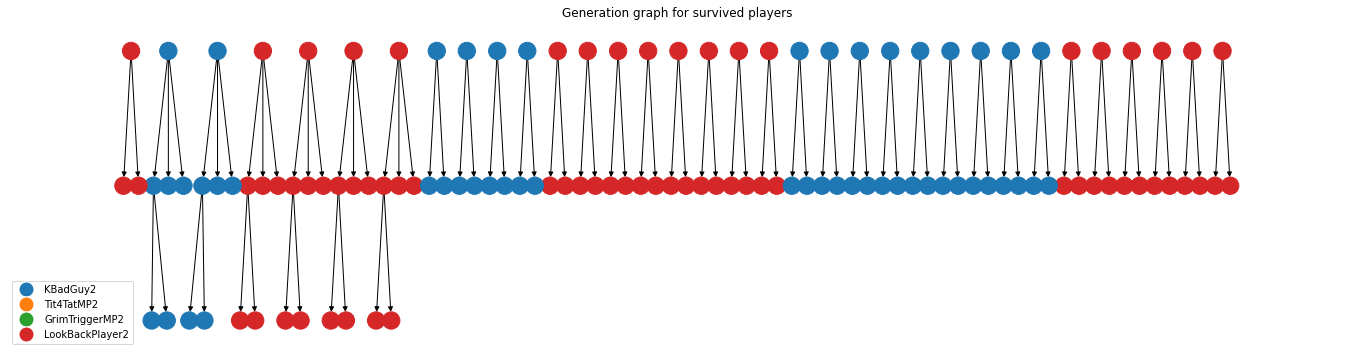

In [35]:
nodes_list = list(G.nodes(data="color"))

for i, color in nodes_list:
    if color in dead_colors:
        G.remove_node(i)

if "graphviz_layout" in dir(nx.drawing.nx_agraph):

    fig, ax = plt.subplots(figsize=(24, 6))
    plt.title("Generation graph for survived players")
    ax.legend(handles=legend_elements)
    pos = graphviz_layout(G, prog="dot")
    nx.draw(
        G,
        pos,
        node_color=nx.get_node_attributes(G, "color").values(),
        with_labels=False,
        labels=nx.get_node_attributes(G, "player_type"),
        arrows=True,
    )

Run again the function and generate an animated bar chart that shows the evolution of the population by player type.

In [42]:
P_list = [
    KBadGuy2(45),
    Tit4TatMP2(c_threshold=0.5),
    GrimTriggerMP2(d_threshold=0.5),
    LookBackPlayer2(bias=0),
]

G, players_type_history = evolvingMPIPD2(P_list, 20, 30, 40, children=2, display_graph=False)

In [43]:
%matplotlib agg

fig = plt.figure()
camera = Camera(fig)
for i, D in enumerate(players_type_history):
    bar = plt.bar(range(len(D)), list(D.values()), color="#1f77b4", align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.legend((bar,), (f"Epoch {i+1}",))
    plt.ylabel("number of players")
    plt.title("Number of players by type")
    camera.snap()

anim = camera.animate(interval=400, repeat_delay=1)
HTML(anim.to_html5_video())

In [41]:
%matplotlib inline